# 1. Importação das bibliotecas e tratamento inicial dos dados

In [ ]:
%%capture
!pip install Bayesian-Optimization
!pip install xgboost
!pip install ray
!pip install unicode
!pip install unidecode

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import requests

import os
import gc
import pdb
import ray
import keras
import tensorflow
import unidecode
from sklearn import metrics
from xgboost import XGBRegressor
from keras.models import load_model
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
def remove_accents(a):
  a = a.encode('utf-8', errors='ignore')
  return unidecode.unidecode(a.decode('utf-8'))

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cadunico = pd.read_csv("/content/drive/MyDrive/Hunger prediction/data/cadunico_data.csv")
metrics = pd.read_csv("/content/drive/MyDrive/Hunger prediction/data/hunger_metrics.csv")

In [ ]:
cadunico['Município'] = cadunico['Município'].str.lower()
cadunico['Município'] = cadunico['Município'].apply(remove_accents)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
metrics.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
metrics

,name,PESO X IDADE / Peso Muito Baixo para a Idade,PESO X ALTURA / Magreza acentuada,CMI
0,abaiara,0.69,2.27,0.000000
1,acarape,0.54,2.97,0.000000
2,acarau,0.44,0.91,3.389831
3,acopiara,0.87,2.75,0.000000
4,aiuaba,0.47,1.43,0.000000
5,alcantaras,0.32,0.65,0.000000
6,altaneira,0.92,3.02,NaN
7,alto santo,0.71,1.84,0.000000
8,amontada,0.33,1.54,0.000000
9,antonina do norte,0.00,0.29,0.000000


In [ ]:
#ìndices das linhas do df em que 'CMI' tem NaN
indices_nulos = metrics[metrics['CMI'].isna()].index

# Novo DataFrame sem as linhas com valores NaN em 'CMI'
metrics = metrics.drop(indices_nulos)

metrics

,name,PESO X IDADE / Peso Muito Baixo para a Idade,PESO X ALTURA / Magreza acentuada,CMI
0,abaiara,0.69,2.27,0.000000
1,acarape,0.54,2.97,0.000000
2,acarau,0.44,0.91,3.389831
3,acopiara,0.87,2.75,0.000000
4,aiuaba,0.47,1.43,0.000000
5,alcantaras,0.32,0.65,0.000000
7,alto santo,0.71,1.84,0.000000
8,amontada,0.33,1.54,0.000000
9,antonina do norte,0.00,0.29,0.000000
10,apuiares,0.63,1.89,125.000000


In [ ]:
# Novo DataFrame sem as linhas com valores NaN em 'CMI'
cadunico = cadunico.drop(indices_nulos)

cadunico

,Município,Faixa da renda total da família / Até 1 S.M.,Faixa da renda total da família / Entre 1 e 2 S.M.,Faixa da renda total da família / Entre 2 e 3 S.M.,Faixa da renda total da família / Acima de 3 S.M.,Faixa da renda familiar per capita / Pobreza 1 (até R$ 109),Faixa da renda familiar per capita / Pobreza 2 (de R$ 109 a R$ 218),Faixa da renda familiar per capita / Baixa Renda,Faixa da renda familiar per capita / Acima de 1/2 S.M.,Recebe PBF família / Não,Recebe PBF família / Sim,Calçamento em frente ao seu domicílio / Total,Calçamento em frente ao seu domicílio / Parcial,Calçamento em frente ao seu domicílio / Não existe,Situação do domicílio / Urbanas,Situação do domicílio / Rurais,Espécie do domicílio / Particular Permanente,Espécie do domicílio / Particular improvisado,Espécie do domicílio / Coletivo,Existência de banheiro / Sim,Existência de banheiro / Não,Forma de abastecimento de água / Rede geral de distribuição,Forma de abastecimento de água / Poço ou nascente,Forma de abastecimento de água / Cisterna,Forma de abastecimento de água / Outra forma,Forma de coleta do lixo / É coletado diretamente,Forma de coleta do lixo / É coletado indiretamente,Forma de coleta do lixo / É queimado ou enterrado na propriedade,"Forma de coleta do lixo / É jogado em terreno baldio ou logradouro (rua, avenida, etc.)",Forma de coleta do lixo / É jogado em rio ou mar,Forma de coleta do lixo / Tem outro destino,Forma de escoamento sanitário / Rede coletora de esgoto ou pluvial,Forma de escoamento sanitário / Fossa séptica,Forma de escoamento sanitário / Fossa rudimentar,Forma de escoamento sanitário / Vala a céu aberto,"Forma de escoamento sanitário / Direto para um rio, lago ou mar",Forma de escoamento sanitário / Outra forma,Material predominante nas paredes externas do domicílio / Alvenaria/tijolo com revestimento,Material predominante nas paredes externas do domicílio / Alvenaria/tijolo sem revestimento,Material predominante nas paredes externas do domicílio / Madeira aparelhada,Material predominante nas paredes externas do domicílio / Taipa revestida,Material predominante nas paredes externas do domicílio / Taipa não revestida,Material predominante nas paredes externas do domicílio / Madeira aproveitada,Material predominante nas paredes externas do domicílio / Palha,Material predominante nas paredes externas do domicílio / Outro Material,Material predominante no piso do domicílio / Terra,Material predominante no piso do domicílio / Cimento,Material predominante no piso do domicílio / Madeira aproveitada,Material predominante no piso do domicílio / Madeira aparelhada,"Material predominante no piso do domicílio / Cerâmica, lajota ou pedra",Material predominante no piso do domicílio / Carpete,Material predominante no piso do domicílio / Outro Material,Água canalizada no domicílio / Sim,Água canalizada no domicílio / Não,Tipo de iluminação / Elétrica com medidor próprio,Tipo de iluminação / Elétrica com medidor comunitário,Tipo de iluminação / Elétrica sem medidor,"Tipo de iluminação / Óleo, querosene ou gás",Tipo de iluminação / Vela,Tipo de iluminação / Outra forma,Recebe PBF família / Não.1,Recebe PBF família / Sim.1,Pessoa com marcação de trabalho infantil / Sim,Pessoa com marcação de trabalho infantil / Não,Não recebe ajuda de terceiros / Opção não marcada no formulário,Não recebe ajuda de terceiros / Opção marcada no formulário,Curso mais elevado que a pessoa frequentou / Creche,Curso mais elevado que a pessoa frequentou / Pré-escola (exceto CA),Curso mais elevado que a pessoa frequentou / Classe de Alfabetização - CA,"Curso mais elevado que a pessoa frequentou / Ensino Fundamental 1ª a 4ª séries, Elementar (Primário), Primeira fase do 1º grau","Curso mais elevado que a pessoa frequentou / Ensino Fundamental 5ª a 8ª séries, Médio 1º ciclo (Ginasial), Segunda fase do 1º grau",Curso mais elevado que a pessoa frequentou / Ensino Fundamental (duração 9 anos),Curso mais elevado que a pessoa frequentou / Ensino Fundamental Especial,"Cur

# 2. Modelos de regressão

In [ ]:
def plot_results(y_pred, y_tes):
  plt.rcParams["figure.figsize"] = (20,6)

  plt.scatter(range(len(y_pred)), y_pred, c='r')
  plt.plot(range(len(y_tes)), y_tes, linestyle="-", marker="o", label="Expenses")
  plt.title('Model performance - test set')
  plt.xlabel('Sample')
  plt.legend(['predicted', 'real'], loc='upper left')
  plt.show()

In [ ]:
column = 3

In [ ]:
x_tr, x_te, y_tr, y_te = train_test_split(cadunico[cadunico.columns[1:]], metrics[metrics.columns[column]], test_size=0.15, random_state=3)

## 2.1. Modelos Lineares

In [ ]:
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn as sk
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [ ]:
def train_test_model(model, x_tr, y_tr, x_te, y_te, folds=5):
  kf = KFold(n_splits = folds, random_state = 1, shuffle=True)
  scores = cross_validate(model, x_tr, y_tr, cv=kf,
                        scoring = ('neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  std_mae = np.std(scores['test_neg_mean_absolute_error']*(-1))

  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  std_mpae = np.std(scores['test_neg_mean_absolute_percentage_error']*(-1))

  r2 = np.mean(scores['test_r2'])
  std_r2 = np.std(scores['test_r2'])

  print('--------------------Validação Cruazada-----------------------')
  print("Média dos valores de MAE: " + str(mae))
  print("Desvio padrão dos valores de MAE: " + str(std_mae) + "\n")

  print("Média dos valores de MAPE: " + str(mape))
  print("Desvio padrão dos valores de MAPE: " + str(std_mpae) + "\n")

  print("Média dos valores de R2: " + str(r2))
  print("Desvio padrão dos valores de R2: " + str(std_r2) + "\n")

  print('--------------------Teste-----------------------')
  y_pred = model.predict(x_te)
  print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
  print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
  print("R2: " + str(r2_score(y_te, y_pred)))

  plot_results(model.predict(x_te), y_te)

### 2.1.1. Regressão Linear

In [ ]:
linear_regressor = sklm.LinearRegression()
linear_regressor.fit(x_tr, y_tr)

LinearRegression()

**Teste com 5-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 923.1951356033107
Desvio padrão dos valores de MAE: 191.1726359429312

Média dos valores de MAPE: 3.249220411720068e+18
Desvio padrão dos valores de MAPE: 6.985221352681914e+17

Média dos valores de R2: -2703.590864906446
Desvio padrão dos valores de R2: 3435.7383435593333

--------------------Teste-----------------------
MAE: 241.625174540487
MAPE: 6.908521828386341e+17
R2: -1.5642048619880158


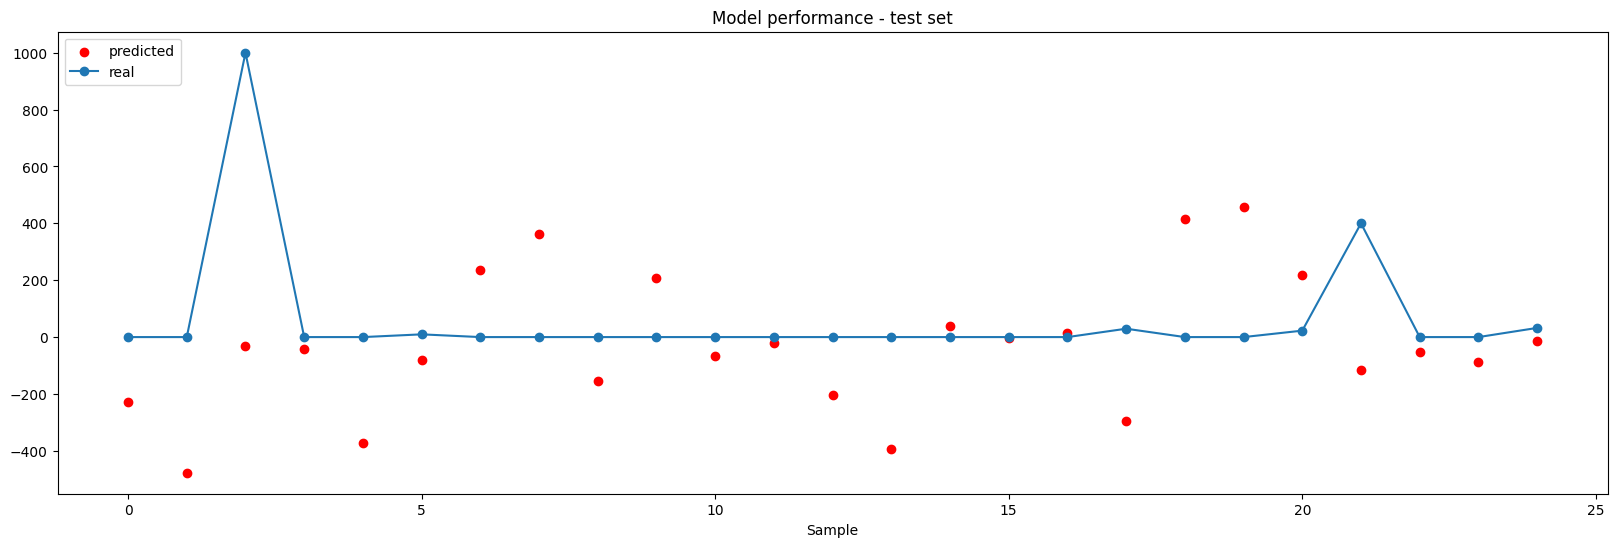

In [ ]:
train_test_model(linear_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**Teste com 10-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 344.3394099694384
Desvio padrão dos valores de MAE: 134.3299640377521

Média dos valores de MAPE: 1.1933675822603233e+18
Desvio padrão dos valores de MAPE: 6.382664525741797e+17

Média dos valores de R2: -7299.060022587076
Desvio padrão dos valores de R2: 10792.97858872557

--------------------Teste-----------------------
MAE: 241.625174540487
MAPE: 6.908521828386341e+17
R2: -1.5642048619880158


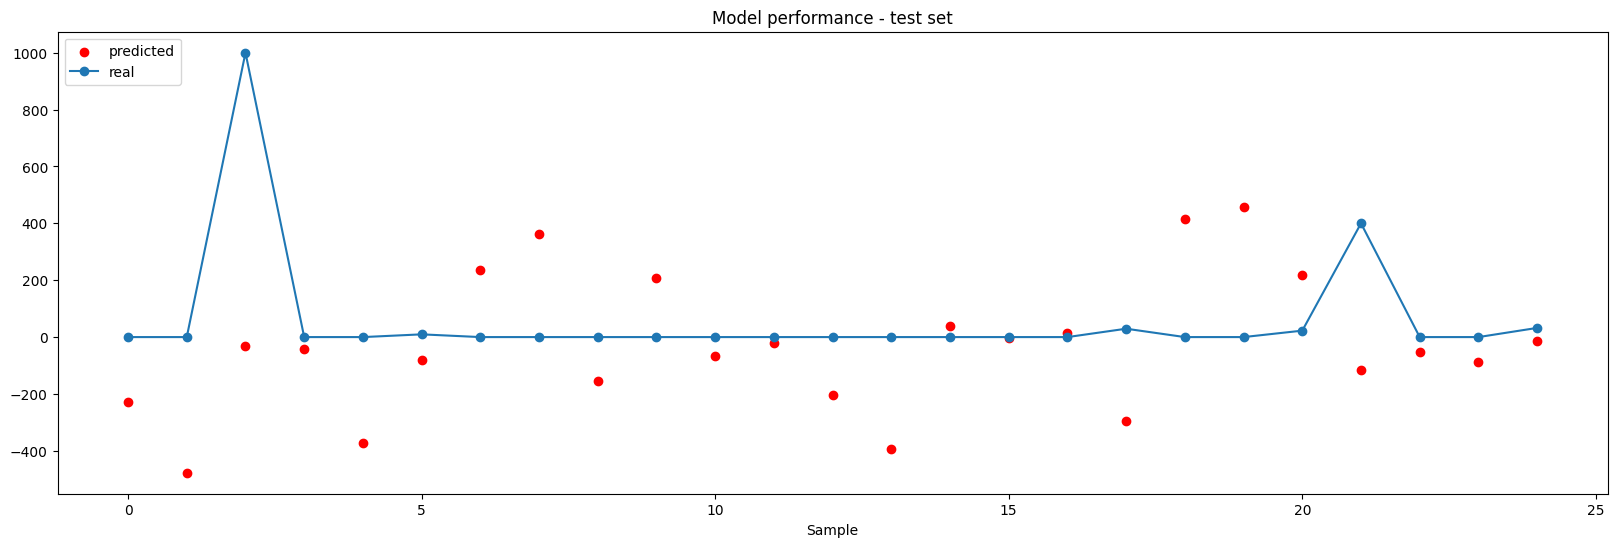

In [ ]:
train_test_model(linear_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 2.1.2. Rgressão Ridge

In [ ]:
ray.init()

2023-11-25 14:36:28,515	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.8.0


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# definindo espaço de busca para os lambdas
lambdas = np.linspace(0, 10000, 1000)

In [ ]:
fld = 5

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  global fld

  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=fld,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
def show_ridge_results():
  result_values = ray.get([test_lambda.remote(i) for i in lambdas])
  scores_MAE = [result[0] for result in result_values]
  scores_MAPE = [result[1] for result in result_values]
  scores_R2 = [result[2] for result in result_values]

  best_index = scores_MAE.index(min(scores_MAE))

  print("Lambda:" + str(lambdas[best_index]))
  print("Best MAE: " + str(scores_MAE[best_index]))
  print("Best MAPE: " + str(scores_MAPE[best_index]))
  print("R2: " + str(scores_R2[best_index]))

  ridge = sklm.Ridge(alpha = lambdas[best_index])
  ridge.fit(x_tr, y_tr)
  plot_results(ridge.predict(x_te), y_te)

**Teste com 5-Folds**

(test_lambda pid=1243) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.69431e-18): result may not be accurate.
(test_lambda pid=1243)   dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
(test_lambda pid=1243) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
(test_lambda pid=1243)   warnings.warn(
(test_lambda pid=1243) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
(test_lambda pid=1243)   warnings.warn(
(test_lambda pid=1243) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
(test_lambda pid=1243)   warnings.warn(
(test_lambda pid=1243) /usr/lo

Lambda:10000.0
Best MAE: 42.9605770273228
Best MAPE: 7.852136796433587e+16
R2: -7.38545513261068


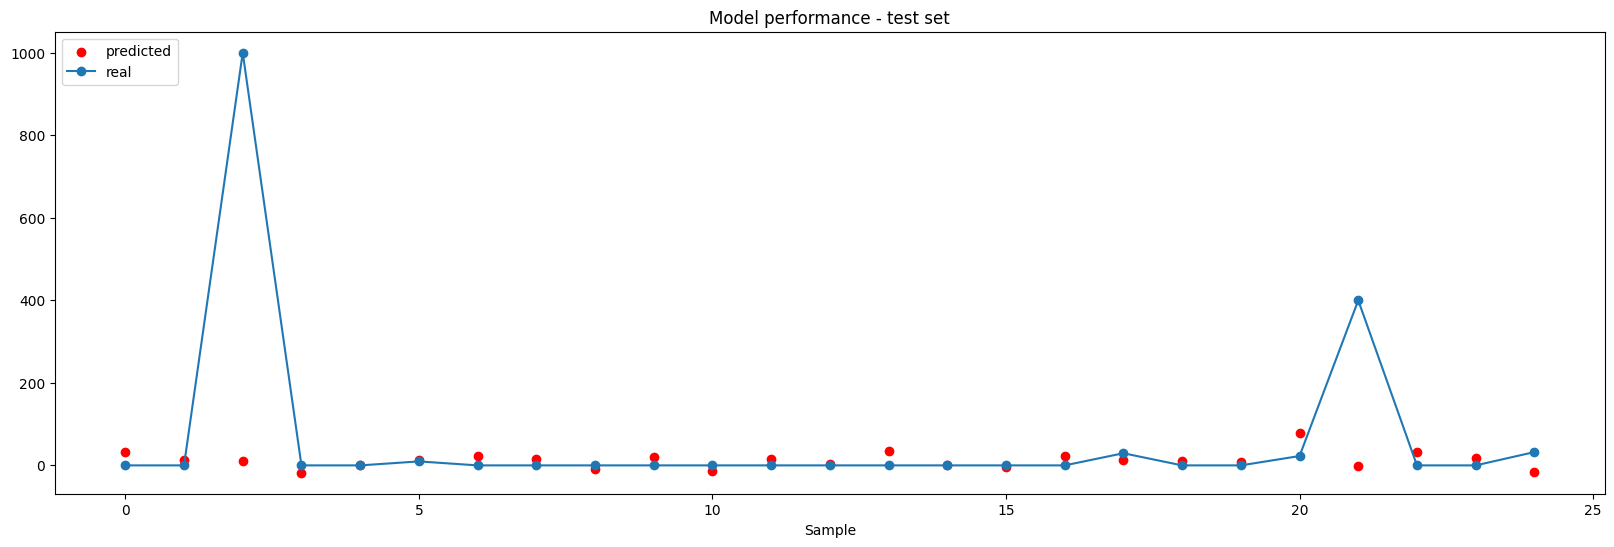

In [ ]:
show_ridge_results()

**Teste com 10-Folds**

(test_lambda pid=1242) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.69431e-18): result may not be accurate.
(test_lambda pid=1242)   dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
(test_lambda pid=1242) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
(test_lambda pid=1242)   warnings.warn(
(test_lambda pid=1242) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
(test_lambda pid=1242)   warnings.warn(
(test_lambda pid=1242) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
(test_lambda pid=1242)   warnings.warn(
(test_lambda pid=1242) /usr/lo

Lambda:10000.0
Best MAE: 42.9605770273228
Best MAPE: 7.852136796433587e+16
R2: -7.38545513261068


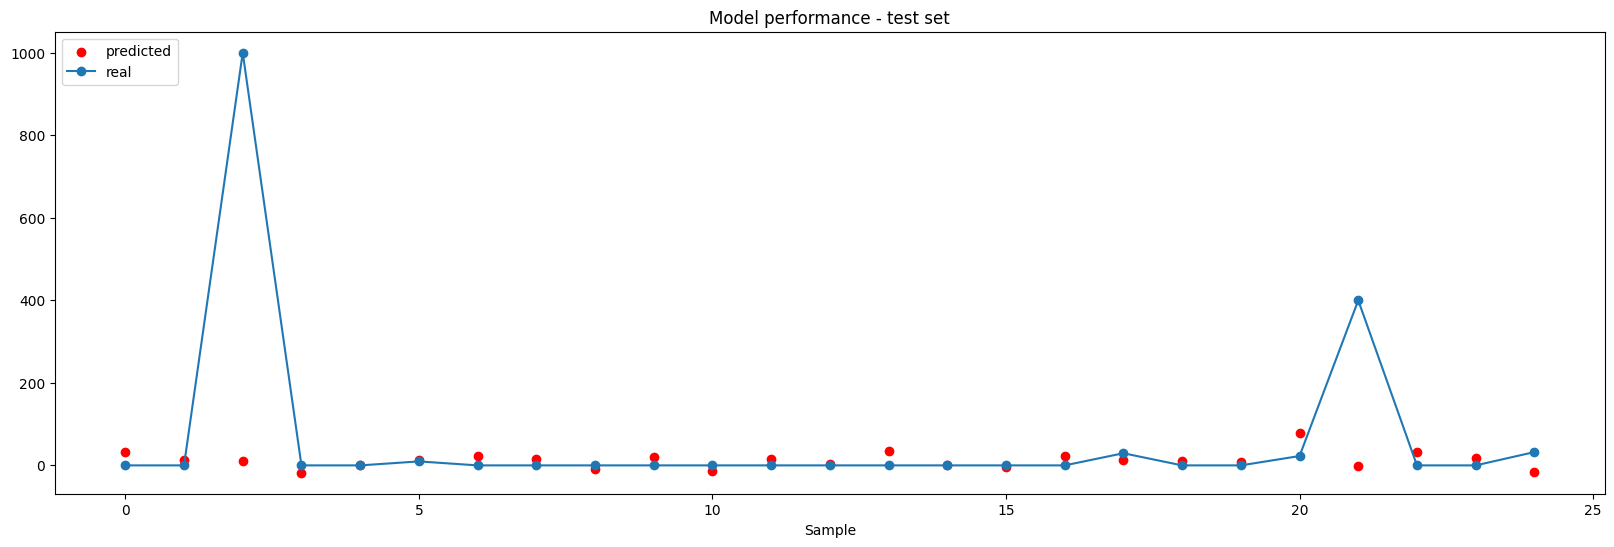

In [ ]:
fld = 10
show_ridge_results()

**Teste com 20-Folds**

(test_lambda pid=1242) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.69431e-18): result may not be accurate.
(test_lambda pid=1242)   dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
(test_lambda pid=1242) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
(test_lambda pid=1242)   warnings.warn(
(test_lambda pid=1242) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
(test_lambda pid=1242)   warnings.warn(
(test_lambda pid=1242) /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
(test_lambda pid=1242)   warnings.warn(
(test_lambda pid=1242) /usr/lo

Lambda:10000.0
Best MAE: 42.9605770273228
Best MAPE: 7.852136796433587e+16
R2: -7.38545513261068


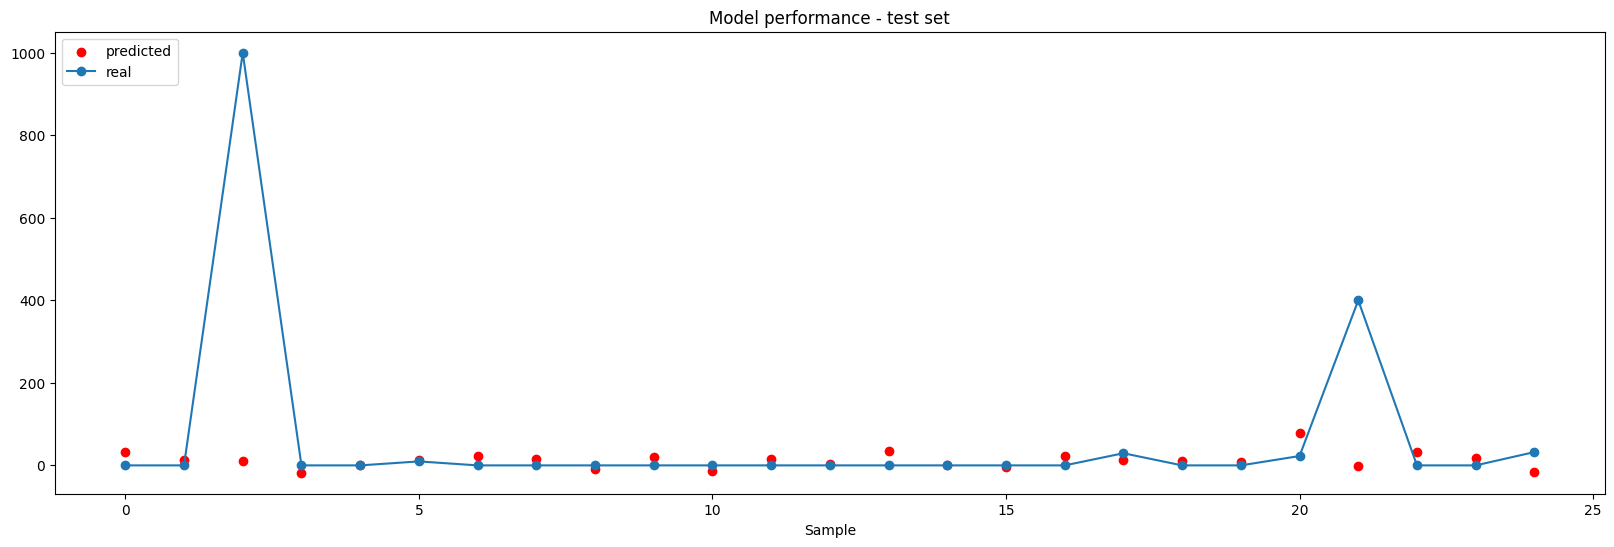

In [ ]:
fld = 20
show_ridge_results()

## 2.2 Modelos não lineares

### 2.2.1. SVM

In [ ]:
from sklearn import svm

In [ ]:
svm_regressor = svm.SVR()
svm_regressor.fit(x_tr, y_tr)

SVR()

**Teste com 5-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 21.11467383287254
Desvio padrão dos valores de MAE: 21.58445965316984

Média dos valores de MAPE: 370206226204481.0
Desvio padrão dos valores de MAPE: 64004140874862.1

Média dos valores de R2: -0.0797070194983243
Desvio padrão dos valores de R2: 0.013889536182804862

--------------------Teste-----------------------
MAE: 59.80605888584577
MAPE: 330244382573615.75
R2: -0.0829420187227925


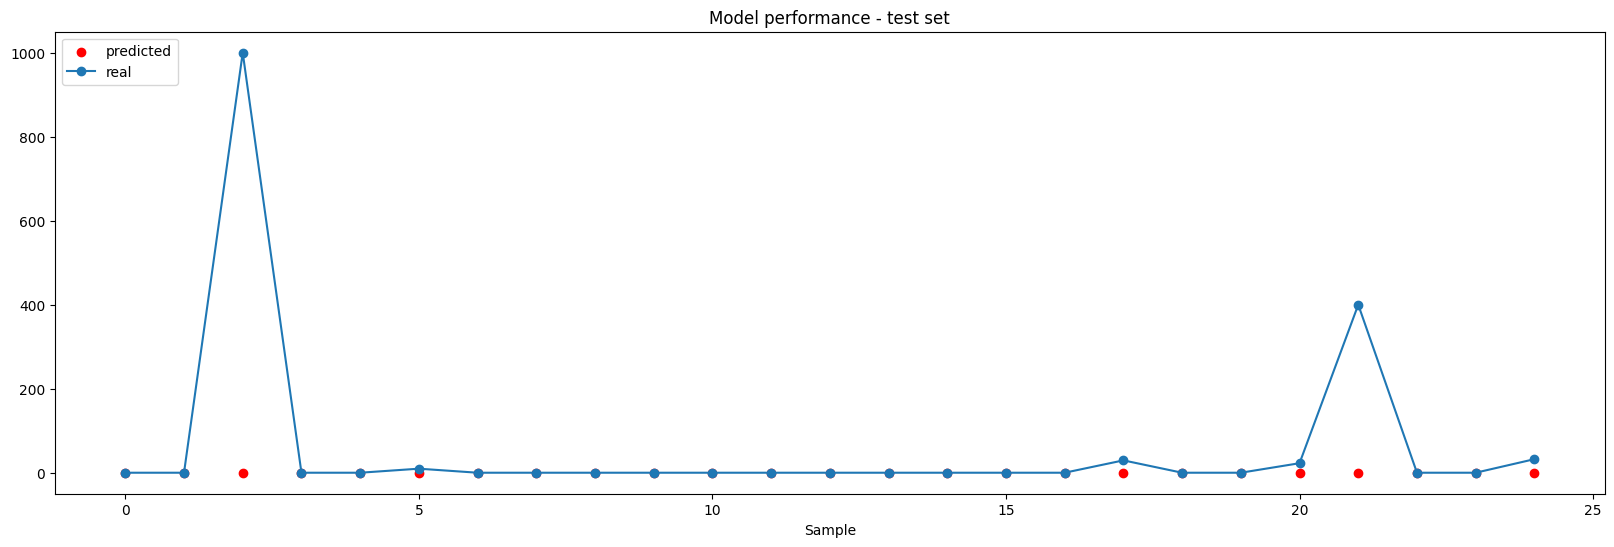

In [ ]:
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**Teste com 10-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 21.23714214307359
Desvio padrão dos valores de MAE: 28.89792318203961

Média dos valores de MAPE: 347821064892492.56
Desvio padrão dos valores de MAPE: 71835816517729.78

Média dos valores de R2: -0.16733428422037308
Desvio padrão dos valores de R2: 0.053253658604275035

--------------------Teste-----------------------
MAE: 59.80605888584577
MAPE: 330244382573615.75
R2: -0.0829420187227925


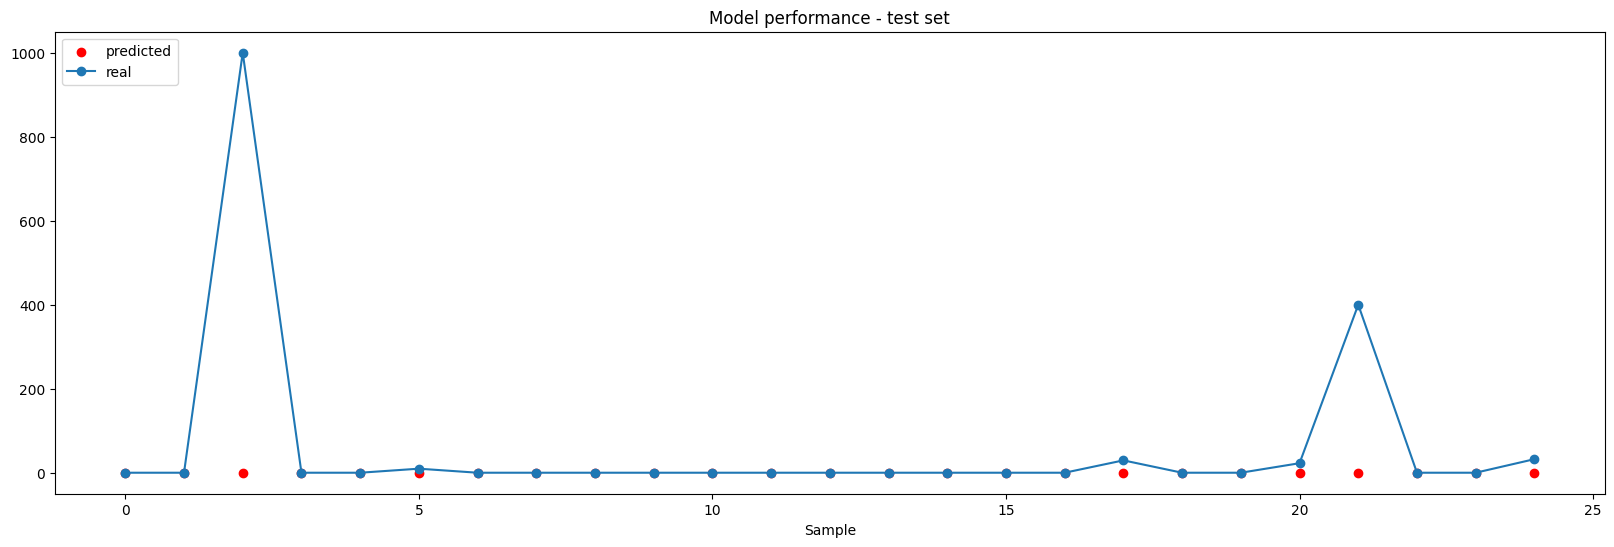

In [ ]:
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 2.2.2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor as rf

In [ ]:
rf_regressor = rf(n_estimators=1000, random_state=1)
rf_regressor.fit(x_tr, y_tr)

RandomForestRegressor(n_estimators=1000, random_state=1)

**Teste com 5-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 47.2723081398203
Desvio padrão dos valores de MAE: 14.894700159568908

Média dos valores de MAPE: 9.953973707192731e+16
Desvio padrão dos valores de MAPE: 4.673683024227574e+16

Média dos valores de R2: -7.19319309001686
Desvio padrão dos valores de R2: 9.437729653394424

--------------------Teste-----------------------
MAE: 82.30474184581536
MAPE: 7.01191698258228e+16
R2: -0.12285255739093182


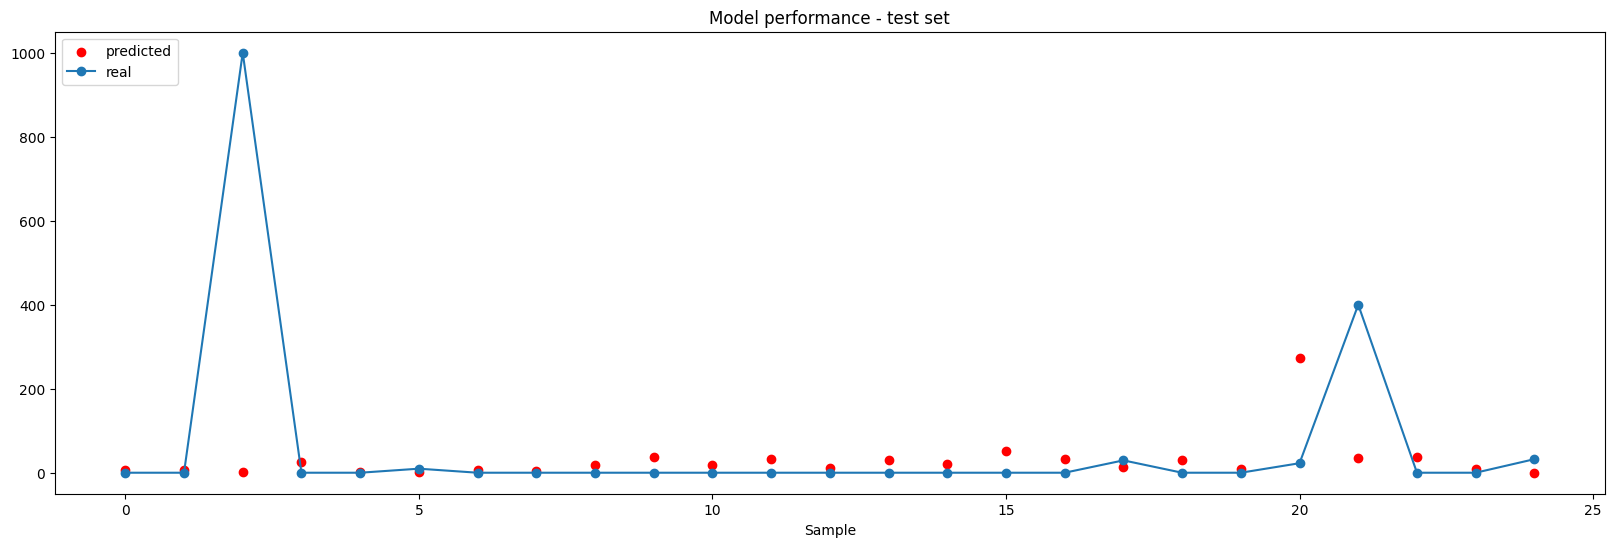

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**Teste com 10-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 51.25449643379257
Desvio padrão dos valores de MAE: 24.011242325829304

Média dos valores de MAPE: 1.0649143004469104e+17
Desvio padrão dos valores de MAPE: 6.022420835583258e+16

Média dos valores de R2: -230.226132167567
Desvio padrão dos valores de R2: 395.4454457789772

--------------------Teste-----------------------
MAE: 82.30474184581536
MAPE: 7.01191698258228e+16
R2: -0.12285255739093182


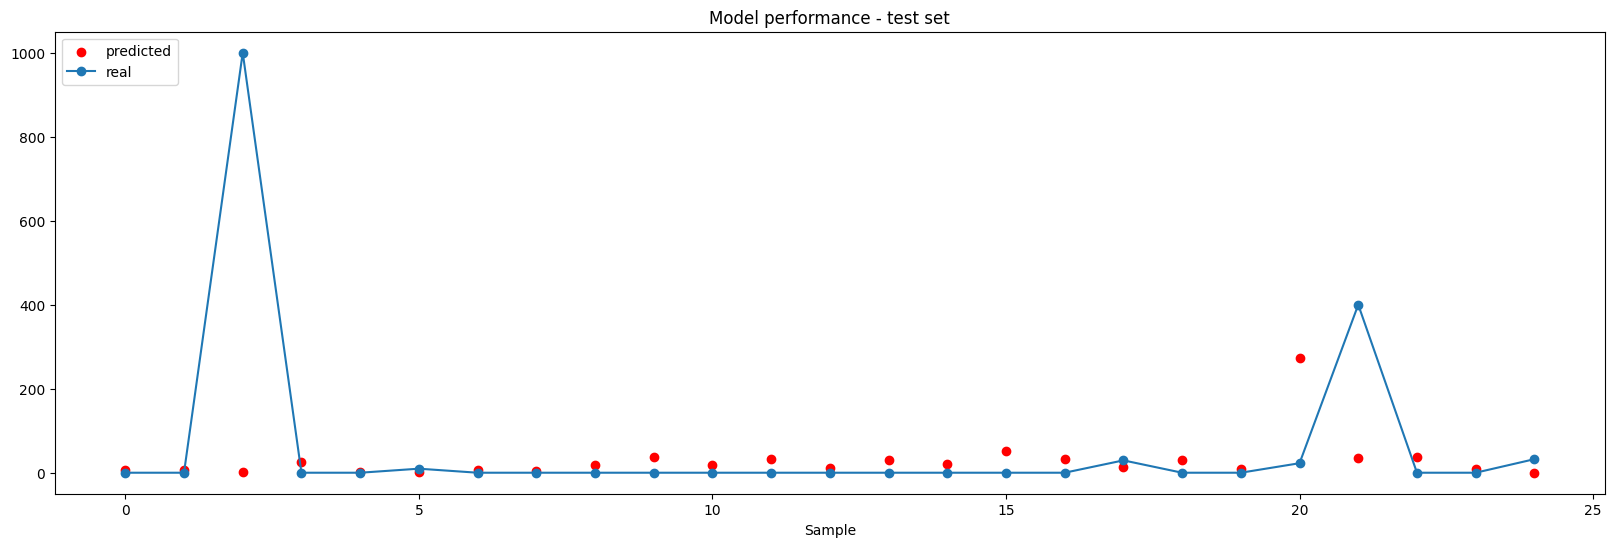

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 2.2.3 XGBoost

**Uma brever explicação de como treinaremos este modelo (o mesmo vale para o *multilayer perceptron* - MLP):**



*   Utilizaremos um algoritmo de otimização (otimização Bayesiana) para otimizar os hiperparâmetros dos modelos. Basicamente, hiperparâmetros são valores configuráveis que podem alterar a forma como o modelo aprende, por exemplo, em uma rede neural multicamadas (MLP) os hiperparâmetros podem ser o número de camadas, o número de nurônios em cada camada, o número de amostras passadas por vez para o modelo durante o treinamento, etc

*   Salvaremos os melhores hiperparâmetros obtidos e o melhor modelo obtido na etapa de cross validation.



In [ ]:
best = np.inf

In [ ]:
def cross_validation_xgb(x_train, y_train, params, folds=5):

  global best

  kf = KFold(n_splits=folds, random_state=1, shuffle=True)
  x_tr = np.array(x_train)
  y_tr = np.array(y_train)
  histories = []
  models = []
  results = []

  for train_index, test_index in kf.split(x_tr):
    xtr, xva = x_tr[train_index], x_tr[test_index]
    ytr, yva = y_tr[train_index], y_tr[test_index]

    model = XGBRegressor(n_estimators=800, early_stopping_rounds = 15, **params)
    model.fit(xtr, ytr, eval_set=[(xtr, ytr), (xva, yva)], verbose=False)
    history = model.evals_result()

    mae = mean_absolute_error(yva, model.predict(xva))
    mape = mean_absolute_percentage_error(yva, model.predict(xva))
    result = {'mae':mae, 'mape':mape}

    histories.append(history)
    models.append(model)
    results.append(result)

    if mae < best:
      best = mae
      model.save_model("best_xgb.model")

  return histories, models, results

In [ ]:
def model_optimize(learning_rate, max_depth, min_child_weight, gamma, subsample,
                   colsample_bytree):

  max_depth = round(max_depth)

  params = {'max_depth':max_depth, 'min_child_weight':min_child_weight, 'gamma':gamma,
            'subsample':subsample, 'colsample_bytree':colsample_bytree,
            'learning_rate':learning_rate, 'eval_metric':["mae", "mape", "logloss"]}


  histories, models, results = cross_validation_xgb(x_tr, y_tr, params, folds=5)

  # pdb.set_trace()

  # model = load_model('_pesos_lstm1.h5')
  # os.remove("_pesos_lstm1.h5")

  plt.rcParams['figure.figsize']=(20,5)
  plt.rcParams.update({'font.size': 20})

  history_mae = np.array([h['validation_0']['mae'] for h in histories])
  history_vmae = np.array([h['validation_1']['mae'] for h in histories])

  plt.plot(np.mean(history_mae, axis=0))
  plt.plot(np.mean(history_vmae, axis=0))
  plt.title('model mae')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  #predict
  model = XGBRegressor(n_estimators=800, early_stopping_rounds = 15, **params)
  model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr)], verbose=False)

  y_pred = model.predict(x_te)
  y_tes = y_te

  plot_results(y_pred, y_tes)

  gc.collect()
  scores = np.array([r['mae'] for r in results])
  return -1*scores.mean()

In [ ]:
pbounds = {'max_depth': (3, 100),
           'learning_rate': (0.001, 1),
           'min_child_weight': (1, 100),
           'gamma': (0, 0.3),
           'subsample': (0.1, 1),
           'colsample_bytree': (0.1, 1),
        }

optimizer = BayesianOptimization(
    f=model_optimize,
    pbounds=pbounds,
    random_state=1
)

# load_logs(optimizer, logs=["./logs.json"])
# logger = JSONLogger(path="./logs.json")
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
optimizer.maximize(init_points=50, n_iter=250)

Output hidden; open in https://colab.research.google.com to view.

**Teste de um modelo "configurado" com os melhores hiperparâmetros obtidos**

In [ ]:
best_hpp = optimizer.max['params']
best_hpp['max_depth'] = round(best_hpp['max_depth'])
best_hpp['eval_metric'] = ["mae", "mape", "logloss"]

In [ ]:
best_xgb = XGBRegressor(n_estimators=100, **best_hpp)
best_xgb.fit(x_tr, y_tr, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5412281703579349, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=['mae', 'mape', 'logloss'], feature_types=None,
             gamma=0.1797330922937635, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.016517742275284887,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=61, max_leaves=None,
             min_child_weight=43.93395854995637, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = best_xgb.predict(x_te)

In [ ]:
print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

MAE: 72.7647454222572
MAPE: 6.663305755862499e+16
R2: -0.058490008427400486


**Teste do melhor modelo obtido na cross validation**

In [ ]:
best_xgb = XGBRegressor()
best_xgb.load_model('best_xgb.model')

y_pred = best_xgb.predict(x_te)

print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

MAE: 79.72060430428094
MAPE: 9.362918960275653e+16
R2: -0.08945828369237674


### 2.2.4. MLP

In [ ]:
best = np.inf

In [ ]:
x_tr.shape

(141, 117)

In [ ]:
import tensorflow
from keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adadelta, Adamax, RMSprop
from tensorflow.keras.layers import PReLU

In [ ]:
def cross_validation(x_train, y_train, dense_layers, neurons_1, neurons_2, neurons_3, optimizer,
                     learning_rate, dropout, folds=5, batch_size=32, callbacks=None):

  global best

  kf = KFold(n_splits=folds, random_state=1, shuffle=True)
  x_tr = np.array(x_train)
  y_tr = np.array(y_train)
  histories = []
  models = []
  results = []

  for train_index, test_index in kf.split(x_tr):
    xtr, xva = x_tr[train_index], x_tr[test_index]
    ytr, yva = y_tr[train_index], y_tr[test_index]

    model = ann(neurons_1, neurons_2, neurons_3, dense_layers, dropout, optimizer,
                learning_rate, xtr)

    history = model.fit(xtr, ytr, validation_data = (xva, yva),
                epochs=800, batch_size = batch_size, callbacks=callbacks,
                verbose=0)

    mae = mean_absolute_error(yva, model.predict(xva))
    mape = mean_absolute_percentage_error(yva, model.predict(xva))
    result = {'mae':mae, 'mape':mape}

    histories.append(history)
    models.append(model)
    results.append(result)

    if mae < best:
      best = mae
      model.save("best_ann.keras")

    break

  return histories, models, results

In [ ]:
def ann(neurons_1, neurons_2, neurons_3, dense_layers, dropout, optimizer, learning_rate, xtr):

  neurons = [neurons_1, neurons_2, neurons_3]

  ann = Sequential()

  for i in range(0, dense_layers):
    if i == 0:
      ann.add(Dense(neurons[i], activation="relu", input_shape=(None, xtr.shape[1])))
      ann.add(Dropout(dropout))
    else:
      ann.add(Dense(neurons[i], activation="relu"))
      ann.add(Dropout(dropout))

  ann.add(Dense(1, activation=None))
  ann.compile(optimizer = optimizer(learning_rate=learning_rate), loss='mae', metrics = 'mae')
  return ann

In [ ]:
def evaluate_network(dense_layers, neurons_1, neurons_2, neurons_3, optimizer, batch_size, learning_rate, dropout):

    dense_layers = round(dense_layers)
    neurons_1 = round(neurons_1); neurons_2 = round(neurons_2); neurons_3 = round(neurons_3)
    optimizer = round(optimizer)
    batch_size = 2**round(batch_size)

    optimizer_array = [Adam, Adadelta, Adamax, RMSprop]
    optimizer_val = optimizer_array[optimizer]

    es = EarlyStopping(monitor="val_mae", mode='min', verbose=0, patience=15)
    # checkpoint = ModelCheckpoint('_pesos_mlp.h5', monitor="val_mae", verbose=0,
    #                                   save_best_only=True, mode='min')

    histories, models, results = cross_validation(x_tr, y_tr,dense_layers, neurons_1,
                                         neurons_2, neurons_3, optimizer_val,
                                         learning_rate, dropout,folds=3,
                                         batch_size=batch_size, callbacks=es)

    plt.rcParams['figure.figsize']=(20,5)
    plt.rcParams.update({'font.size': 20})

    history_mae = np.array([h.history['mae'] for h in histories])
    history_vmae = np.array([h.history['val_mae'] for h in histories])

    plt.plot(np.mean(history_mae, axis=0))
    plt.plot(np.mean(history_vmae, axis=0))
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    #predict
    model = ann(neurons_1, neurons_2, neurons_3, dense_layers, dropout, optimizer_val, learning_rate, x_tr)

    es = EarlyStopping(monitor="mae", mode='min', verbose=0, patience=15)
    model.fit(x_tr, y_tr, epochs=800, batch_size = batch_size, callbacks=es, verbose=0)

    y_pred = model.predict(x_te)
    y_tes = y_te

    plot_results(y_pred, y_tes)

    #calculating score
    score = -1*np.mean([r['mae'] for r in results])

    gc.collect()
    return score

In [ ]:
pbounds = {'dense_layers': (1, 3),
           'neurons_1': (1, 16),
           'neurons_2': (1, 8),
           'neurons_3': (1, 4),
           'optimizer': (0, 3),
           'batch_size': (5, 7),
           'learning_rate': (0.0001, 1),
           'dropout': (0, 0.5)
        }

optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    random_state=2
)

# load_logs(optimizer, logs=["./logs.json"])
# logger = JSONLogger(path="./logs.json")
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
optimizer.maximize(init_points=50, n_iter=250)

Output hidden; open in https://colab.research.google.com to view.

**Teste de um modelo "configurado" com os melhores hiperparâmetros obtidos**

In [ ]:
params = optimizer.max['params']

In [ ]:
params['dense_layers'] = round(params['dense_layers'])
params['neurons_1'] = round(params['neurons_1'])
params['neurons_2'] = round(params['neurons_2'])
params['neurons_3'] = round(params['neurons_3'])
params['batch_size'] = 2**round(params['batch_size'])

optimizer_array = [Adam, Adadelta, Adamax, RMSprop]
params['optimizer'] = optimizer_array[round(params['optimizer'])]

In [ ]:
model = ann(params['neurons_1'], params['neurons_2'], params['neurons_3'],
            params['dense_layers'], params['dropout'], params['optimizer'],
            params['learning_rate'], x_tr)

In [ ]:
es = EarlyStopping(monitor="mae", mode='min', verbose=0, patience=15)
model.fit(x_tr, y_tr, epochs=800, batch_size = params['batch_size'], callbacks=es, verbose=0)

In [ ]:
y_pred = model.predict(x_te)

print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

1/1 [==============================] - 0s 60ms/step
MAE: 59.781480124759284
MAPE: 107152706455470.31
R2: -0.0831832169173643


**Teste do melhor modelo obtido na cross validation**

In [ ]:
best_ann = keras.models.load_model('best_ann.keras')

y_pred = best_ann.predict(x_te)

print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

1/1 [==============================] - 0s 59ms/step
MAE: 59.7272600526165
MAPE: 3585347346759.919
R2: -0.08314736926733945


### 2.2.5 Custom KNN

In [ ]:
def get_distance(d1, targets, d2=None, nn=3):

  flag = False
  if type(d2) == type(None):
    d2 = d1
    flag = True

  distances_matrix = []

  for i, row2 in enumerate(d2):
    distances = []

    for j, row1 in enumerate(d1):
      # pdb.set_trace()
      distances.append(math.dist(row1, row2))

    targets_for_dist = targets.copy()
    targets_for_dist = [x for _,x in sorted(zip(distances, targets_for_dist))]
    distances = sorted(distances)

    if flag == True:
      targets_for_dist = targets_for_dist[1:]
      distances = distances[1:]

    targets_for_dist = targets_for_dist[:nn]
    distances = distances[:nn]

    distances = np.reciprocal(np.array(distances))
    targets_for_dist = np.array(targets_for_dist)

    distances_matrix.append(np.multiply(distances, targets_for_dist))


  return np.array(distances_matrix)


In [ ]:
xnn_tr = get_distance(d1 = np.array(x_tr), targets = np.array(y_tr), nn=2)
xnn_te = get_distance(d1 = np.array(x_tr), d2 = np.array(x_te), targets = np.array(y_te), nn=2)

**Aplicando o SVM às distâncias:**

In [ ]:
from sklearn import svm

In [ ]:
svm_regressor = svm.SVR()
svm_regressor.fit(xnn_tr, y_tr)

SVR()

**Teste com 5-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 21.10102461904006
Desvio padrão dos valores de MAE: 21.585338533004947

Média dos valores de MAPE: 323255022847732.9
Desvio padrão dos valores de MAPE: 49566456196341.17

Média dos valores de R2: -0.07980350132724032
Desvio padrão dos valores de R2: 0.014117197333517068

--------------------Teste-----------------------
MAE: 59.76572939852049
MAPE: 315777566773765.94
R2: -0.08286503023494562


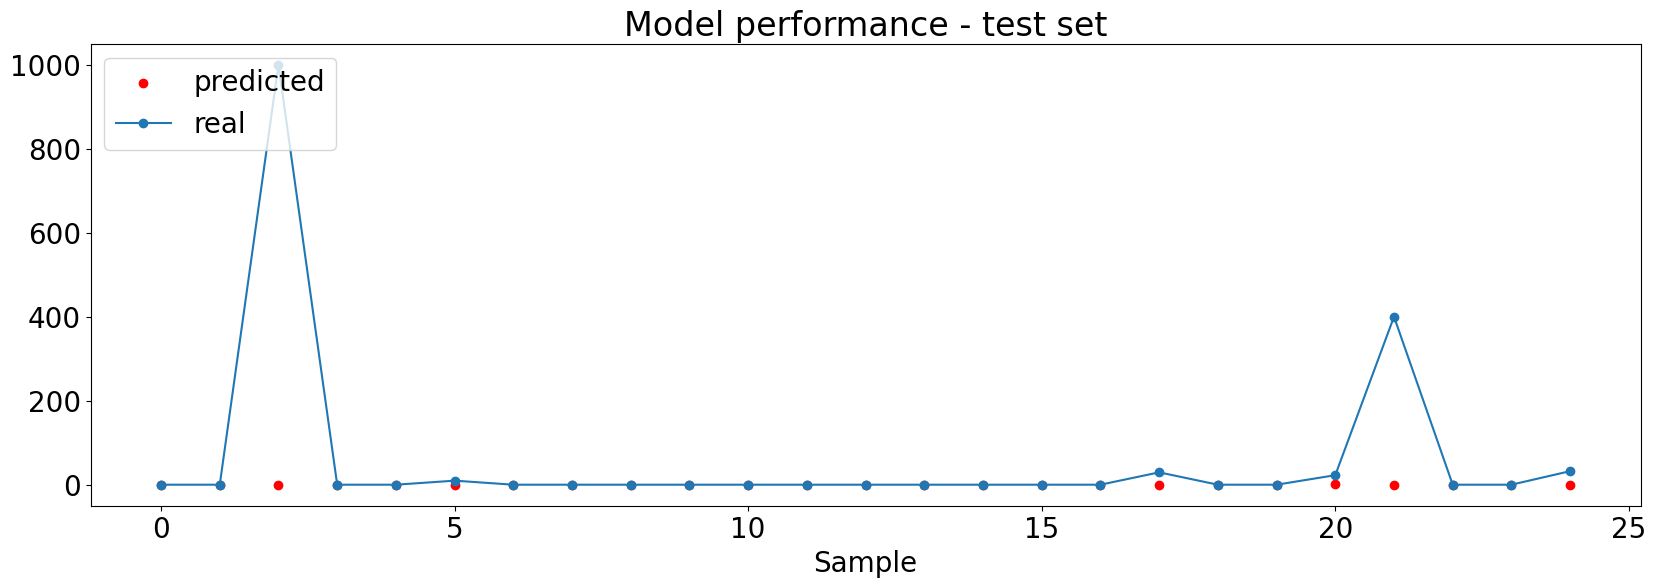

In [ ]:
train_test_model(svm_regressor, xnn_tr, y_tr, xnn_te, y_te, folds=5)

**Teste com 10-Folds**

--------------------Validação Cruazada-----------------------
Média dos valores de MAE: 21.227960310973707
Desvio padrão dos valores de MAE: 28.901515729671885

Média dos valores de MAPE: 321427754136574.7
Desvio padrão dos valores de MAPE: 62881876217452.35

Média dos valores de R2: -0.16669015717606034
Desvio padrão dos valores de R2: 0.049522179830439425

--------------------Teste-----------------------
MAE: 59.76572939852049
MAPE: 315777566773765.94
R2: -0.08286503023494562


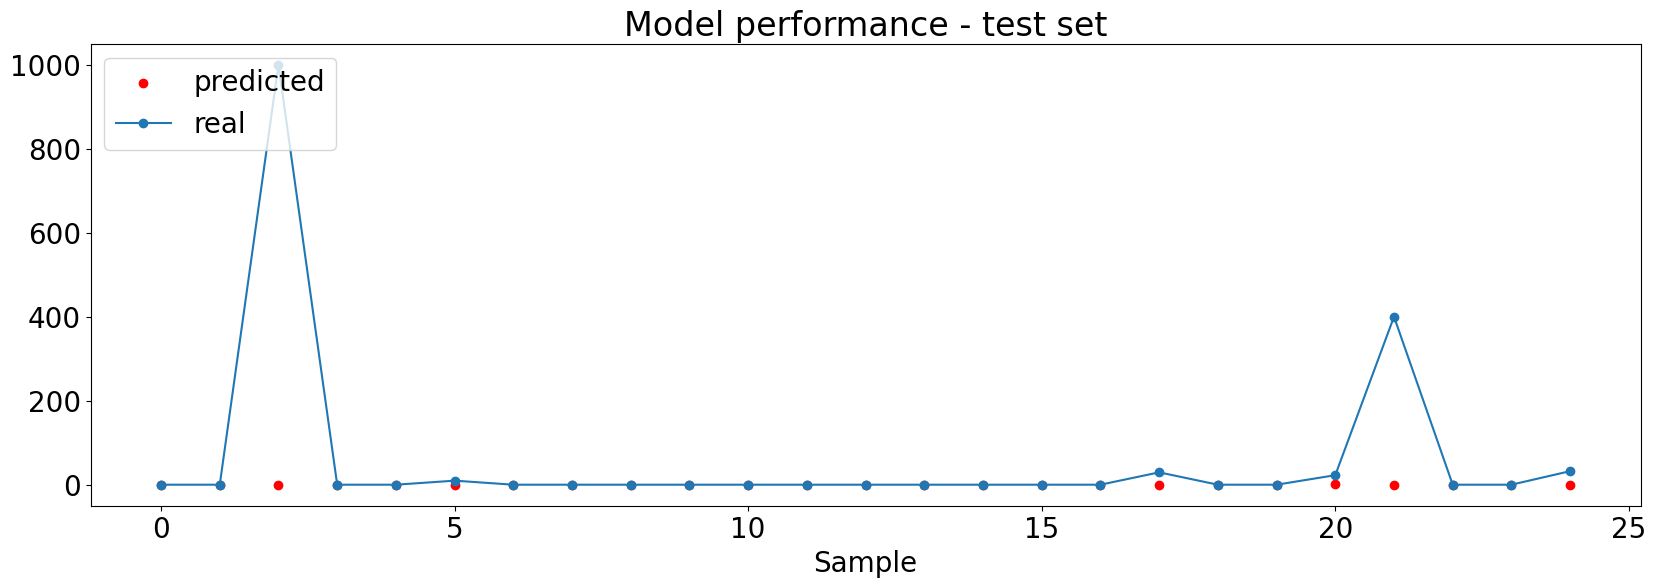

In [ ]:
train_test_model(svm_regressor, xnn_tr, y_tr, xnn_te, y_te, folds=10)